# Building a CNN to detect abnormalities on X-ray images (MURA dataset)

## Description of the dataset
MURA (musculoskeletal radiographs) is a large dataset of bone X-rays. Algorithms are tasked with determining whether an X-ray study is normal or abnormal.


The data is split into categories determined by one of the following types of scans:
   * XR_ELBOW
   * XR_FINGER
   * XR_FOREARM
   * XR_HAND
   * XR_HUMERUS
   * XR_SHOULDER
   * XR_WRIST
    
    
It is further split according to the patients' ID and then the specific study performed on said patient.
Each study can contain one or more images of the X-ray scan, which are lebaled either as positive or negative, depending on the existence of an abnormality in the musculoskeletal region.

## Imports

In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import roc_curve, auc

import cv2
import matplotlib.pyplot as plt

import time
import warnings

## Constants and Settings

In [6]:
# files
TRAIN_PATHS = 'MURA-v1.1/train_image_paths.csv'
TRAIN_LABELS = 'MURA-v1.1/train_labeled_studies.csv'
VALID_PATHS = 'MURA-v1.1/valid_image_paths.csv'
VALID_LABELS = 'MURA-v1.1/valid_labeled_studies.csv'

RAND_SEED = 333
SAVE_MODEL = True # constant to stop accidentally loading images again
SAVE_DN169 = True # constant to stop accidentally re-training model

FILTERS = ["ALL", # all images
           "ONE_PER_STUDY", # only one image (first one) per study
           "XR_ELBOW", # only images of specified body part 
           "XR_FINGER", 
           "XR_FOREARM",
           "XR_HAND", 
           "XR_HUMERUS",
           "XR_SHOULDER",
           "XR_WRIST"]

# ------------------------------------------------------------------------------------------------------------------------#
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

## Data preprocessing

In [22]:
def filter_data(filter_type, train_paths, train_labels, valid_paths, valid_labels):
    """
    Selects only a specified subset of data for training.
    
    filter_type : str
        constant which defines the subset (see section Constants and Settings above)
    trian_paths, train_labels, valid_paths, valid_labels : pandas.DataFrame
        dataframes containing paths to all sets of data and its labels
    """
    if filter_type == "ALL":
        return train_paths, train_labels, valid_paths, valid_labels
    
    elif filter_type == "ONE_PER_STUDY":
        filt_train_paths = train_paths.loc[train_paths.path.str.contains('.*image1.png')]
        filt_valid_paths = valid_paths.loc[valid_paths.path.str.contains('.*image1.png')]
        return filt_train_paths, train_labels, filt_valid_paths, valid_labels
    
    else:
        filt_train_paths = train_paths.loc[train_paths.path.str.contains(filter_type)]
        filt_valid_paths = valid_paths.loc[valid_paths.path.str.contains(filter_type)]
        filt_train_labels = train_labels.loc[train_labels.path.str.contains(filter_type)]
        filt_valid_labels = valid_labels.loc[valid_labels.path.str.contains(filter_type)]
        return filt_train_paths, filt_train_labels, filt_valid_paths, filt_valid_labels

def load_data(train_paths, valid_paths, verbose):
    """
    Takes paths to images in training and validation set and uses them to load actual image data into NumPy arrays.
    
    trian_paths, valid_paths : pandas.DataFrame
        dataframes containing paths to all sets of data
    verbose : bool
        if True, function prints progress of loading
    """
    # load training set images
    train_images = []
    if verbose:
        print(f'Loading training images...')
        cnt, i, j = len(train_paths), 1, 0
        
    for index, row in train_paths.iterrows():
        if verbose and j >= i * (cnt // 10):
            print(f' - {i * 10}%', end='')
            i += 1
        train_images.append(cv2.imread(row.path))
        j += 1
    
    # load validation set images
    valid_images = []
    if verbose:
        print(f'\nLoading validation images...')
        cnt, i, j = len(valid_paths), 1, 0
        
    for index, row in valid_paths.iterrows():
        if verbose and j >= i * (cnt // 10):
            print(f' - {i * 10}%', end='')
            i += 1
        valid_images.append(cv2.imread(row.path))
        j += 1

    return train_images, valid_images


def show_sample_grid(images):
    """
    Prints a 5x5 grid with examples of given images.
    
    images : NumPy.ndarray
        contains image data of a certain dataset from which we wish to display a few examples
    """
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
    plt.show()
        

def prep_data(data_paths, input_size, filter_type, show_sample=False, verbose=False):
    """
    Function takes in paths to data and outputs training and validation sets ready for model training.
    
    data_paths : list
        contains two elements, where the first is a list containing paths to training data and labels
        and the second contains paths to validation data and labels
    input_size : tuple
        (width, height) that the images will be resized to
    show_sample : bool
        if True, function prints a grid preview of several images from the training set
    """
    
    # read csv files into dataframes
    train_paths_df = pd.read_csv(data_paths[0][0], header=None, names=['path'])
    train_labels_df = pd.read_csv(data_paths[0][1], header=None, names=['study_path', 'abnormal'])
    valid_paths_df = pd.read_csv(data_paths[1][0], header=None, names=['path'])
    valid_labels_df = pd.read_csv(data_paths[1][1], header=None, names=['study_path', 'abnormal'])
    
    # filter data if only a subset is to be considered
    train_paths_df, train_labels_df, valid_paths_df, valid_labels_df = filter_data(
        filter_type, train_paths_df, train_labels_df, valid_paths_df, valid_labels_df)
    
    # load images
    train_images, valid_images = load_data(train_paths_df, valid_paths_df, verbose)
    
    # load labels for images
    if verbose:
        print('\nLoading labels...')
    train_labels, valid_labels = np.array(train_labels_df.abnormal.tolist()), np.array(valid_labels_df.abnormal.tolist())

    # resize images to given input size
    if verbose:
        print('Resizing images...')
    for i in range(len(train_images)):
        train_images[i] = cv2.resize(train_images[i], input_size)
    for i in range(len(valid_images)):
        valid_images[i] = cv2.resize(valid_images[i], input_size)
        
    train_images = np.array(train_images)
    valid_images = np.array(valid_images)
    
    # TODO preprocessing here
    
    if show_sample:
        show_sample_grid(train_images)
        
    return train_images, train_labels, valid_images, valid_labels
    

In order to simplify the problem and the CNN architecture for now, I have reduced the number of images per study to just one by using the *ONE_PER_STUDY* filtering option



Based on the MURA baseline and the paper published along with it, I will resize all images to 320 x 320 pixels in order to have consisent inputs for the CNN



Loading training images...
 - 10% - 20% - 30% - 40% - 50% - 60% - 70% - 80% - 90% - 100%
Loading validation images...
 - 10% - 20% - 30% - 40% - 50% - 60% - 70% - 80% - 90% - 100%
Loading labels...
Resizing images...


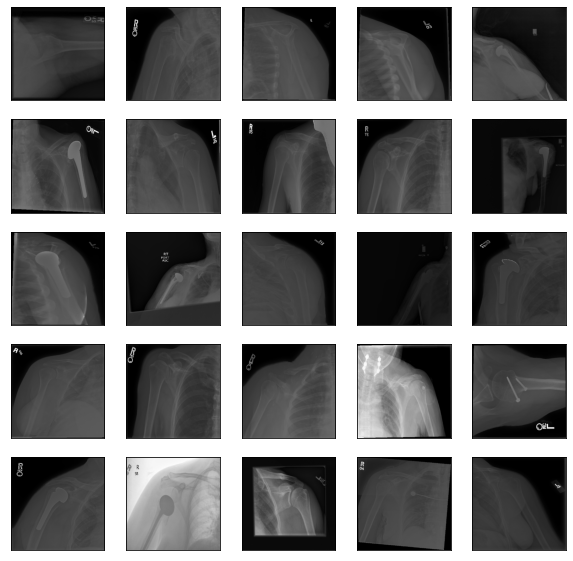

Finished after 235.09 seconds


In [23]:
start = time.time()
train_images, train_labels, valid_images, valid_labels = prep_data(
    [[TRAIN_PATHS, TRAIN_LABELS], [VALID_PATHS, VALID_LABELS]], (320, 320), FILTERS[1], True, True)
print(f'Finished after {(time.time() - start):.2f} seconds')

In [24]:
# check train and validation set sizes
print(train_images.shape)
print(train_labels.shape)
print(valid_images.shape)
print(valid_labels.shape)

(13457, 320, 320, 3)
(13457,)
(1199, 320, 320, 3)
(1199,)


## Build model

Setup convolutional base with 3 x 3 feature filters (number of filters increases as input sizes get smaller)

MaxPooling 2 x 2 filter to reduce feature sizes

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(24, (3, 3), padding='same', activation='relu', input_shape=(320, 320, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Classify image based on extracted features by first flattening the feature vector, then fully connecting to dense layer of 64 neurons and finally connecting those to the output neuron

In [26]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 320, 320, 24)      672       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 160, 160, 24)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 158, 158, 32)      6944      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 77, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 36, 36, 64)       

## Train model

In [28]:
np.reshape(train_images, [-1, 320, 320, 3])
np.reshape(valid_images, [-1, 320, 320, 3])

model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'])
    
history = model.fit(x=train_images, y=train_labels, epochs=3, validation_data=(valid_images, valid_labels), verbose=2)

Train on 13457 samples, validate on 1199 samples
Epoch 1/3
13457/13457 - 339s - loss: 5.9364 - accuracy: 0.6151 - val_loss: 6.9213 - val_accuracy: 0.5513
Epoch 2/3
13457/13457 - 338s - loss: 5.9341 - accuracy: 0.6153 - val_loss: 6.9213 - val_accuracy: 0.5513
Epoch 3/3
13457/13457 - 332s - loss: 5.9341 - accuracy: 0.6153 - val_loss: 6.9213 - val_accuracy: 0.5513


loss: 5.9341 - accuracy: 0.6153 - val_loss: 6.9213 - val_accuracy: 0.5513

## Test model

In [29]:
preds = model.predict(valid_images, verbose=1)

1199/1199 [==============================] - 10s 8ms/sample


In [30]:
valid_loss, valid_acc = model.evaluate(valid_images, valid_labels, verbose=1)

1199/1199 [==============================] - 10s 8ms/sample - loss: 6.9213 - accuracy: 0.5513


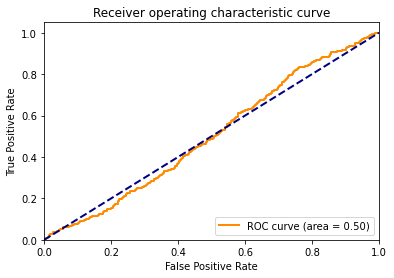

In [31]:
fpr, tpr, _ = roc_curve(valid_labels, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [32]:
if SAVE_MODEL:
    model.save('mura_basic_model.h5')

# -----------------------------------------------------------------------------------------------------------

# Preloading the DenseNet169 architecture and testing it on MURA

The Stanford baseline uses the DenseNet169 architecture as the convolutional base of its model, so I will attempt to load it and use it as well

## Load convolutional base

In [109]:
base_model = tf.keras.applications.DenseNet169(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000
)

base_model.trainable = False # freeze base

## Create classifier and merge models

Picks global averages from the pool of features

In [110]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Output layer

In [111]:
prediction_layer = tf.keras.layers.Dense(1)

In [112]:
densenet_model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [113]:
densenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, None, None, 1664)  12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________


## Train model

In [114]:
base_learning_rate = 0.0001

densenet_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

See how evaluating the model goes before even training it

In [115]:
initial_epochs = 3

loss0, accuracy0 = densenet_model.evaluate(valid_images, valid_labels)

1199/1199 [==============================] - 245s 204ms/sample - loss: 1.2905 - accuracy: 0.4912


In [116]:
densenet_history = densenet_model.fit(x=train_images, y=train_labels,
                    epochs=initial_epochs,
                    validation_data=(valid_images, valid_labels),
                    verbose=2)

Train on 13457 samples, validate on 1199 samples
Epoch 1/3
13457/13457 - 2947s - loss: 0.6627 - accuracy: 0.6131 - val_loss: 0.9587 - val_accuracy: 0.5580
Epoch 2/3
13457/13457 - 4196s - loss: 0.6223 - accuracy: 0.6282 - val_loss: 1.2319 - val_accuracy: 0.5521
Epoch 3/3
13457/13457 - 2845s - loss: 0.6003 - accuracy: 0.6441 - val_loss: 1.4342 - val_accuracy: 0.5513


loss: 0.6003 - accuracy: 0.6441 - val_loss: 1.4342 - val_accuracy: 0.5513

## Test model

In [117]:
preds_dn = densenet_model.predict(valid_images, verbose=1)

1199/1199 [==============================] - 220s 184ms/sample


In [118]:
valid_loss, valid_acc = densenet_model.evaluate(valid_images, valid_labels, verbose=1)

1199/1199 [==============================] - 212s 177ms/sample - loss: 1.4342 - accuracy: 0.5513


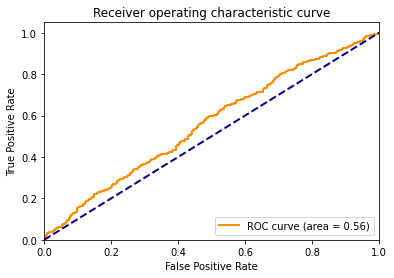

In [119]:
fpr, tpr, _ = roc_curve(valid_labels, preds_dn)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [120]:
if SAVE_DN169:
    densenet_model.save('mura_densenet169.h5')